In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage, MakeNegativeSample
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

  0%|          | 0/54000 [00:00<?, ?it/s]

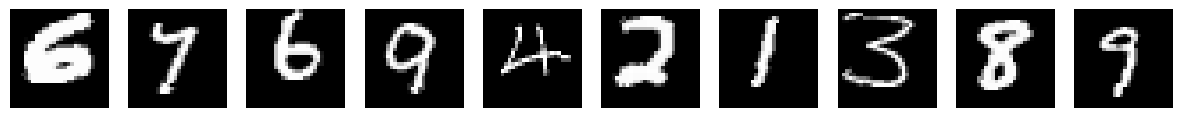

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [28]:
torch.manual_seed(seed)

# Scale img transform
class Scale(object):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        return img * self.scale_factor + 0.5 * (1 - self.scale_factor)

# Inverse Logistic Sigmoid Transform
class InvLogit(object):
    def __call__(self, x):
        return torch.log(x / (1 - x))

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.1
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
pos_train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
neg_train_dataset = PreloadedDataset.from_dataset(pos_train_dataset, MakeNegativeSample(pos_train_dataset), device)


pos_val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
neg_val_dataset = PreloadedDataset.from_dataset(pos_val_dataset, MakeNegativeSample(pos_val_dataset), device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = pos_train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', pos_train_dataset.transformed_images.max())
print('Min value: ', pos_train_dataset.transformed_images.min())

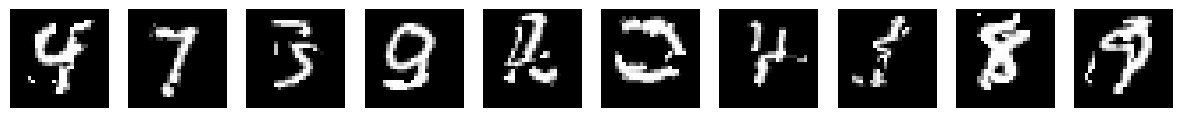

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [29]:
neg_train_dataset.apply_transform()
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = neg_train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', neg_train_dataset.transformed_images.max())
print('Min value: ', neg_train_dataset.transformed_images.min())

In [30]:
def train(
        model,
        BATCH_SIZE,
        NUM_EPOCHS,
        pos_train_dataset,
        pos_val_dataset,
        neg_train_dataset,
        neg_val_dataset,
        optimiser,
        scheduler,
        stats,
        eval_every=500,
):
    # Init data
    pos_trainX = pos_train_dataset.transformed_images.flatten(1).reshape(-1, BATCH_SIZE, INPUT_SHAPE)
    neg_trainX = neg_train_dataset.transformed_images.flatten(1).reshape(-1, BATCH_SIZE, INPUT_SHAPE)
    valLoader = torch.utils.data.DataLoader(pos_val_dataset, batch_size=128, shuffle=False)

    # Init particles
    pos_train_states = [model.init_state(x) for x in pos_trainX]
    neg_train_states = [model.init_state(x) for x in neg_trainX]
    # neg_states = [model.init_state(x) for x in trainX]

    gamma = torch.ones(BATCH_SIZE, device=device) * 0.5

    # Init trackers
    if stats is None:
        stats = {
            'epoch': 0,
            'trainVfe': [],
            'negVfe': [],
            'valVfe': [],
            'valAcc': [],
        }

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochTrainVfes = []
        # epochNegVfes = []

        # TQDM loop
        loop = tqdm(range(len(pos_train_states)), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'steps': i, 'trainVFE': stats['trainVfe'][-1], 'valVFE': stats['valVfe'][-1]})#, 'negVFE': stats['negVfe'][-1]})#, 'valVFE': stats['valVfe'][-1], 'valAcc': stats['valAcc'][-1]})

        # Iterate over all batches
        for batch_idx in loop:
            # Update positive and negative particles
            model.step(pos_train_states[batch_idx], pin_obs=True, temp=0.0, gamma=gamma)
            # model.step(neg_train_states[batch_idx], pin_obs=True, temp=0.0, gamma=gamma)

            # Compute positive and negative VFEs
            pos_train_vfe = model.vfe(pos_train_states[batch_idx])
            # neg_train_vfe = model.vfe(neg_train_states[batch_idx])

            # Update model parameters
            optimiser.zero_grad()
            loss = pos_train_vfe
            # loss = pos_train_vfe / pos_train_vfe.item() # <--- Without negative particles
            # loss = pos_train_vfe / pos_train_vfe.item() - neg_train_vfe / neg_train_vfe.item() # <--- With negative particles
            loss.backward()
            optimiser.step()

            # Track batch stats
            epochTrainVfes.append(pos_train_vfe.item())
            # epochNegVfes.append(neg_train_vfe.item())

        # Track epoch stats
        stats['trainVfe'].append(torch.tensor(epochTrainVfes).mean().item())
        # stats['negVfe'].append(torch.tensor(epochNegVfes).mean())

        # Update learning rate
        if scheduler is not None:
            scheduler.step(stats['trainVfe'][-1])

        # Validation pass
        if i % eval_every == 0:
            val_results = val_pass(model, None, valLoader, True, False, None)
            stats['valVfe'].append(val_results['vfe'].item())
            stats['valAcc'].append(val_results['acc'].item())
            # neg_states = [model.init_state(x) for x in trainX]
            # negY = format_y((train_dataset.targets + torch.randint_like(train_dataset.targets, 1, 9)) %10, NUM_CLASSES).reshape(-1, BATCH_SIZE, NUM_CLASSES)
        
        stats['epoch'] += 1
    
    return stats


In [31]:
torch.manual_seed(seed)

model_name = 'original'
model = FCPCN(
    sizes=[784, 200, 200, 32],
    bias=True, 
    symmetric=True, 
    # actv_fn=F.sigmoid,
    actv_fn=F.relu,
    # actv_fn=shrinkage,
    steps=20,
    gamma=0.2,
    temp_k=0.0,
    x_decay=0.0,
).to(device)
stats = None
optimiser = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=50, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-9)

In [33]:
BATCH_SIZE = 100
NUM_EPOCHS = 500
stats = train(
    model,
    BATCH_SIZE,
    NUM_EPOCHS,
    pos_train_dataset,
    pos_val_dataset,
    neg_train_dataset,
    neg_val_dataset,
    optimiser,
    scheduler,
    None,
    25,
)

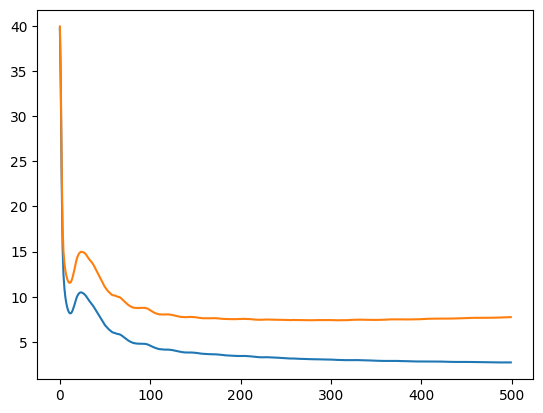

In [43]:
plt.plot(stats['trainVfe'], label='Train VFE')
# plt.plot(stats['negVfe'], label='Neg VFE')

In [44]:
def train_classifier(
        model,
        classifier,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        stats,
):
    # Init data
    trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=200, shuffle=False)

    # Init trackers
    if stats is None:
        stats = {
            'epoch': 0,
            'trainLoss': [],
            'valAcc': [],
            'valLoss': [],
        }

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochLosses = []

        optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.001)  

        # TQDM loop
        loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'steps': i, 'valAcc': stats['valAcc'][-1], 'valLoss': stats['valLoss'][-1]})

        # Iterate over all batches
        for (images, labels) in loop:
            images = images.flatten(1)

            out, state = model(images)
            out = classifier(out.detach())

            model.zero_grad()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimiser.step()
            epochLosses.append(loss.item())

        # Track epoch stats
        stats['trainLoss'].append(torch.tensor(epochLosses).mean())

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['ValAcc'][-1])

        # Validation pass
        val_results = val_pass(model, classifier, valLoader, True, True, None)
        stats['valAcc'].append(val_results['acc'].item())
        stats['valLoss'].append(val_results['loss'].item())
        
        stats['epoch'] += 1
    
    return stats

In [45]:
class_stats = None
classifier = nn.Sequential(
    nn.Linear(600, 200, bias=True, device=device),
    nn.ReLU(),
    nn.Linear(200, NUM_CLASSES, bias=False, device=device),
).to(device)
class_stats = train_classifier(
    model,
    classifier,
    NUM_EPOCHS,
    pos_train_dataset,
    pos_val_dataset,
    class_stats,
    # eval_every=10,
)

KeyboardInterrupt: 

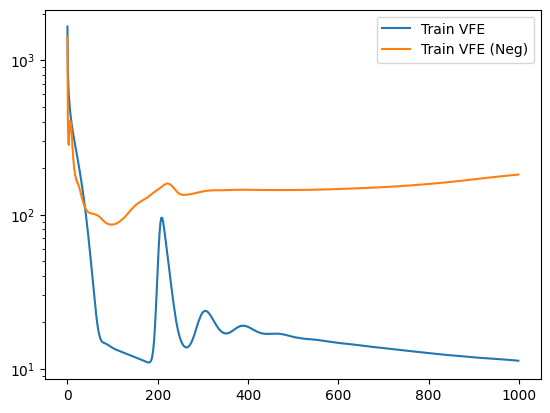

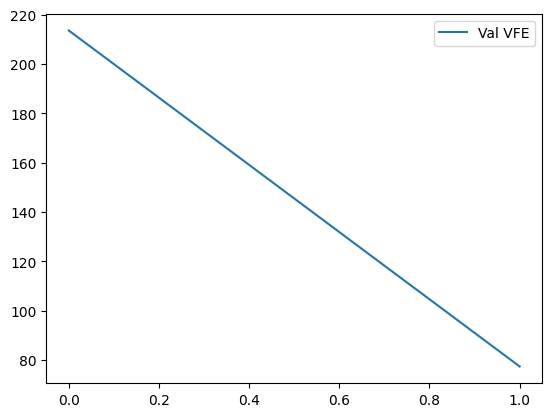

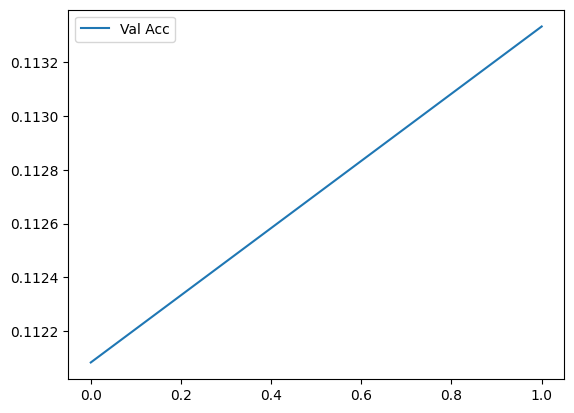

In [11]:
plt.plot(stats['trainVfe'], label='Train VFE')
plt.plot(stats['negVfe'], label='Train VFE (Neg)')
# plt.plot(sameneg_stats['trainVfe'], label='Train VFE (Neg)')
# plt.plot(noneg_nonorm_stats['trainVfe'], label='Train VFE (No Norm)')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(stats['valVfe'], label='Val VFE')
# plt.plot(stats['valVfe'], label='Val VFE (Neg)')
# plt.plot(noneg_nonorm_stats['valVfe'], label='Val VFE (No Norm)')
plt.legend()
plt.show()

plt.plot(stats['valAcc'], label='Val Acc')
# plt.plot(sameneg_stats['valAcc'], label='Val Acc (Neg)')
# plt.plot(noneg_nonorm_stats['valAcc'], label='Val Acc (No Norm)')
plt.legend()
plt.show()

torch.Size([784])

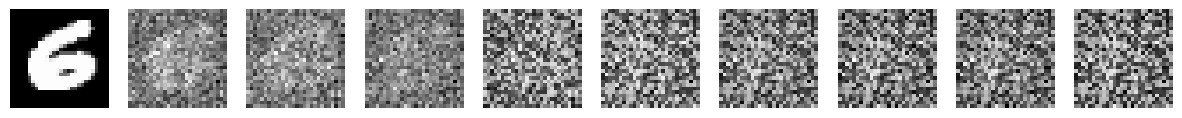

In [33]:
trainX = train_dataset.transformed_images.flatten(1).reshape(-1, BATCH_SIZE, INPUT_SHAPE)
state = model.init_state(trainX[0])

# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = state[0]['x'][0].cpu().reshape(28,28).detach()
    ax.imshow(img, cmap='gray')
    model.step(state, temp=0.0, gamma=0.5)
    ax.axis('off')
state[0]['x'][0].shape